## Algorithm

[Psuedocode for all 3 helper EEGLAB programs joint probability.](https://github.com/NeuroDataDesign/orange-panda/blob/master/notes/bad_chan_detect/eeglab-bad-electrode.pdf)

In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import matlab.engine
eng = matlab.engine.start_matlab()
import os
# Fix random seed
initseed = 123456789
np.random.seed(initseed)
import StringIO
out = StringIO.StringIO()

In [2]:
a = np.ones((3,4,5,6))
a = np.rollaxis(a, 3)
print a.shape
a = np.rollaxis(a, 3)
print a.shape

(6, 3, 4, 5)
(5, 6, 3, 4)


In [168]:
# Write wrapper pop_jointprob
# inEEG = C x T x N, channels x trials x timepoints, numpy array
# elecrange = range of electrodes, list/numpy array
# locthresh = threshold for individual electrode inspection
# globthresh = threshold for entire dataset inspection
def pop_jointprob(inEEG, elecrange, locthresh, globthresh):
    # first, do localized individual electrode inspection
    jp, rej = jointprob(inEEG[elecrange,:,:], locthresh, 1)
    # now reshape data for global inspection
    globEEG = np.rollaxis(inEEG, 2)
    np.reshape(globEEG, (globEEG.shape[0], globEEG.shape[1] * globEEG.shape[2]))
    # run global inspection
    jpG, rejG = jointprob(globEEG[elecrange,:,:], globthresh, 1)
    return jp, rej, jpG, rejG

# Histogram binning implementation
# D = T x N, D = data Trials, Number of timepts
# b = bins, default 1000
def realproba(D, b = 1000):
    SIZE = D.shape[0] * D.shape[1]
    P = np.zeros(b)
    P_dist = np.zeros(b)
    minimum = np.min(D)
    maximum = np.max(D)
    D = np.floor((D - minimum)/(maximum - minimum) * (b - 1)).astype(int)
    D_flat = np.ndarray.flatten(D)
    for i in range(SIZE):
        P_dist[D_flat[i]] = P_dist[D_flat[i]] + 1
    P = P_dist[D] / SIZE
    P_dist = P_dist / SIZE
    if P_dist.ndim < P.ndim:
        P_dist = np.expand_dims(P_dist, P.ndim - P_dist.ndim)
    return P, P_dist.T

This will run well with a small range of data.

For test data will just use our dataset (for now).

Also, here will import the actual MATLAB algorithm.

In [4]:
def to_matlab(arr):
    # Modify string for MATLAB processing
    test_split = str(arr).split()
    for k in range(len(test_split)):
        if test_split[k][-1:] == "]":
            test_split[k] = test_split[k] + ";"
        elif test_split[k] != "[[" and test_split[k] != "[":
            if test_split[k+1] != "]" and test_split[k+1] != "]]":
                test_split[k] = test_split[k] + ","
    newstr = ' '.join(test_split)
    return newstr

In [5]:
os.chdir("/home/nitin/hopkins/neurodata/orange-panda/notes/bad_chan_detect")
a = np.array([[2, 2, 2, 3], [2, 2, 2, 3], [2, 2, 2, 3], [2, 2, 2, 3]])
e, f = realproba(a, 6)
c, d = eng.realproba(eng.eval(str(a)), 6.0, stdout = out, nargout = 2)
print np.array_equal(e, c)
print e
print c

test_split = str(a).split()
for i in range(len(test_split)):
    if test_split[i][-1:] == "]":
        test_split[i] = test_split[i] + ";"
    elif test_split[i] != "[[" and test_split[i] != "[":
        test_split[i] = test_split[i] + ","
newstr = ' '.join(test_split)
print newstr
newstr = to_matlab(a)
print newstr
c, d = eng.realproba(eng.eval(newstr), 6.0, stdout = out, nargout = 2)
print np.array_equal(e, c)
print e
print c

True
[[ 0.75  0.75  0.75  0.25]
 [ 0.75  0.75  0.75  0.25]
 [ 0.75  0.75  0.75  0.25]
 [ 0.75  0.75  0.75  0.25]]
[[0.75,0.75,0.75,0.25],[0.75,0.75,0.75,0.25],[0.75,0.75,0.75,0.25],[0.75,0.75,0.75,0.25]]
[[2, 2, 2, 3]; [2, 2, 2, 3]; [2, 2, 2, 3]; [2, 2, 2, 3]];
[[2, 2, 2, 3]; [2, 2, 2, 3]; [2, 2, 2, 3]; [2, 2, 2, 3]];
True
[[ 0.75  0.75  0.75  0.25]
 [ 0.75  0.75  0.75  0.25]
 [ 0.75  0.75  0.75  0.25]
 [ 0.75  0.75  0.75  0.25]]
[[0.75,0.75,0.75,0.25],[0.75,0.75,0.75,0.25],[0.75,0.75,0.75,0.25],[0.75,0.75,0.75,0.25]]


***
## Simulated Data

### To check realproba

- Make random 1D and 2D arrays:
    - 10 4x4 2D arrays, range of values 0-10, 15-25 bins
    - 10 30 1D arrays, range of values 0-50, 55-65 bins
    - 10 30 x 30 2D arrays, range of values 0-50, 55-65 bins

## Realproba Simulated Data First

In [6]:
def probdata(case):
    bins = 0
    array = []
    if case == 0:
        bins = np.floor(np.random.uniform(15, 25))
        array = np.random.uniform(0, 10, size = (4, 4))
    elif case == 1:
        bins = np.floor(np.random.uniform(50, 60))
        array = np.random.uniform(0, 50, size = (1, 30))
    else:
        bins = np.floor(np.random.uniform(50, 60))
        array = np.random.uniform(0, 50, size = (30,30))
    return array, bins
    
array = np.random.uniform(0, 50, size = (30, 30))
print array.ndim

2


Real proba data will just look like random noise

In [7]:
def eval_proba(arr1, arr2):
    return np.array_equal(np.asarray(arr1), np.asarray(arr2))

In [8]:
test = probdata(2)
test_split = str(test[0]).split()
for i in range(len(test_split)):
    if test_split[i][-1:] == "]":
        test_split[i] = test_split[i] + ";"
    elif test_split[i] != "[[" and test_split[i] != "[":
        test_split[i] = test_split[i] + ","
newstr = ' '.join(test_split)
# print newstr
        
out = StringIO.StringIO()
test_prob, test_dist = eng.realproba(
            eng.eval(newstr), float(test[1]), stdout = out, nargout = 2)
# print out.getvalue()

In [9]:
test_split = str(test[0]).split()
for i in range(len(test_split)):
    if test_split[i][-1:] == "]":
        test_split[i] = test_split[i] + ";"
    elif test_split[i] != "[[" and test_split[i] != "[":
        test_split[i] = test_split[i] + ","

print test_split[0]
print test_split[1]
print test_split[30]
print test_split[31]
print test_split[32]
print test_split[61]
print test_split[62]
print test_split[92]

newstr = ' '.join(test_split)
# print newstr

[[
33.45481988,
46.0673176,
];
[
32.55836417,
36.2722741,
22.19313188,


Real Proba Case 0


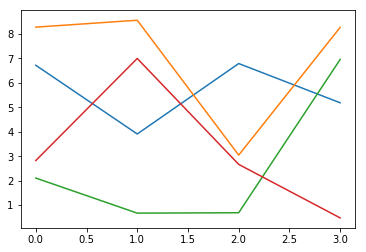

P equivalence: True
P_dist equivalence: True


/home/nitin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:77: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/nitin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:78: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


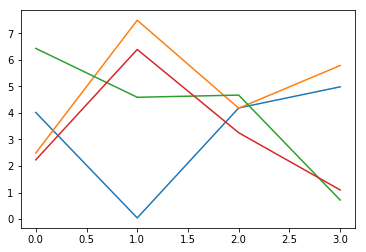

P equivalence: True
P_dist equivalence: True


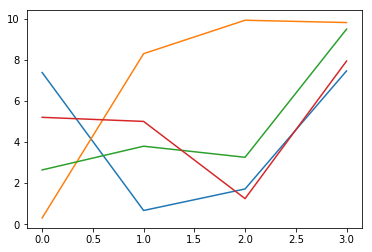

P equivalence: True
P_dist equivalence: True


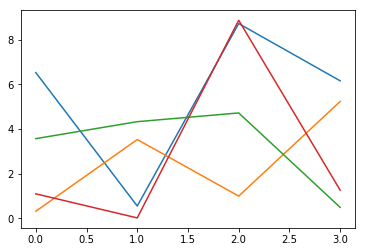

P equivalence: True
P_dist equivalence: True


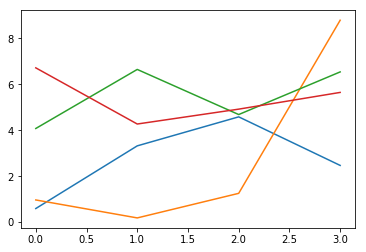

P equivalence: True
P_dist equivalence: True


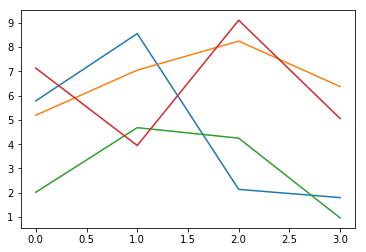

P equivalence: True
P_dist equivalence: True


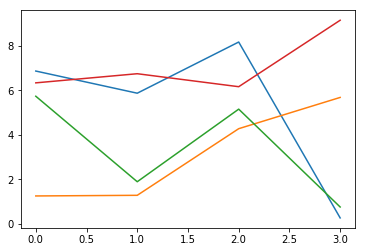

P equivalence: True
P_dist equivalence: True


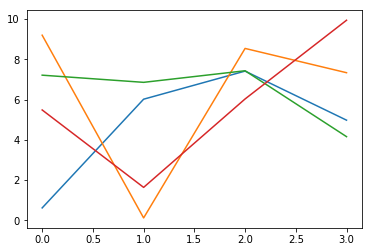

P equivalence: True
P_dist equivalence: True


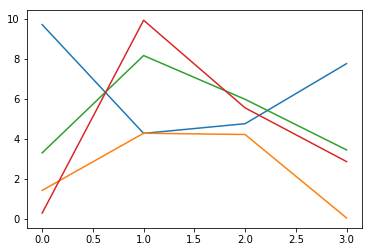

P equivalence: True
P_dist equivalence: True


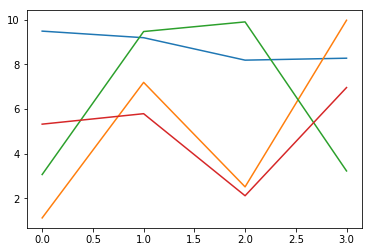

P equivalence: True
P_dist equivalence: True



Real Proba Case 1


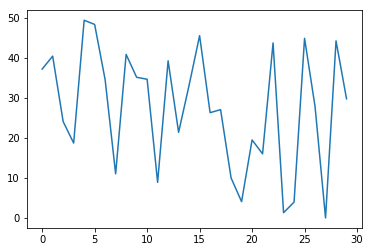

P equivalence: True
P_dist equivalence: True


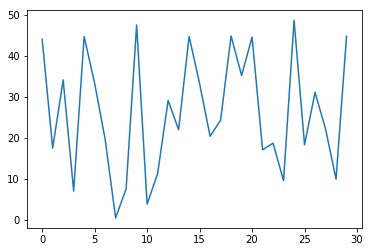

P equivalence: True
P_dist equivalence: True


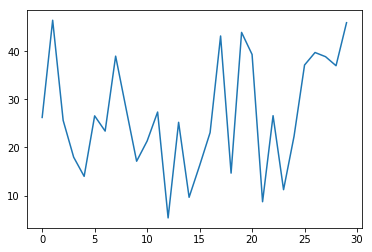

P equivalence: True
P_dist equivalence: True


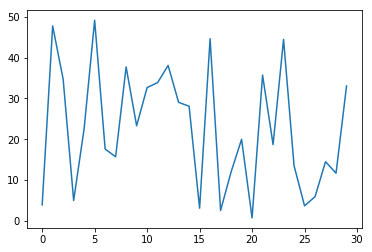

P equivalence: True
P_dist equivalence: True


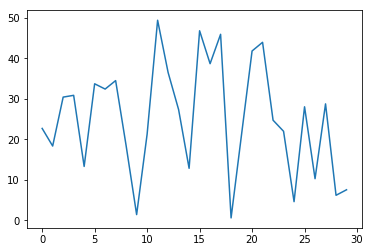

P equivalence: True
P_dist equivalence: True


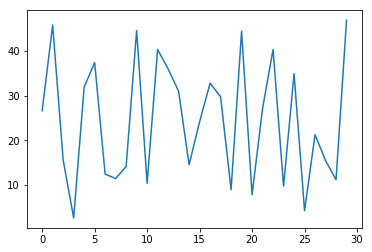

P equivalence: True
P_dist equivalence: True


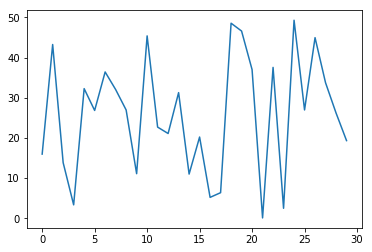

P equivalence: True
P_dist equivalence: True


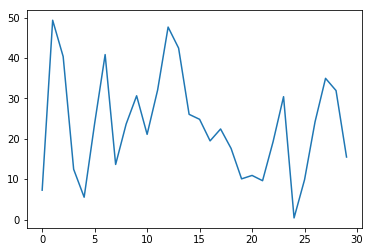

P equivalence: True
P_dist equivalence: True


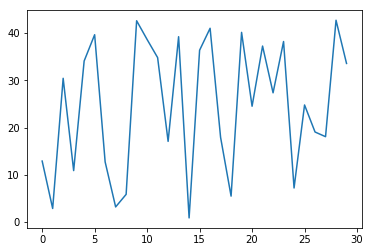

P equivalence: True
P_dist equivalence: True


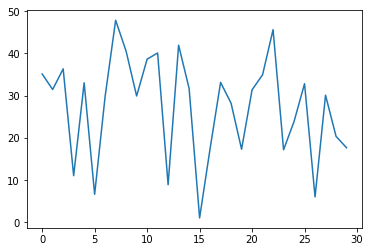

P equivalence: True
P_dist equivalence: True



Real Proba Case 2


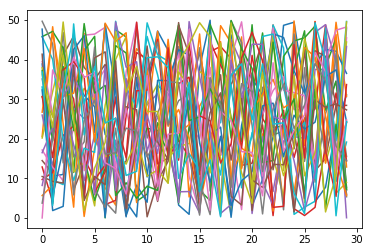

P equivalence: True
P_dist equivalence: True


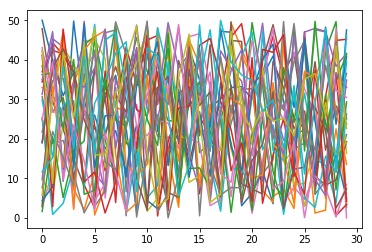

P equivalence: True
P_dist equivalence: True


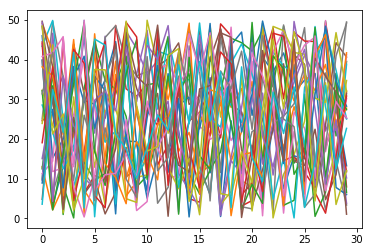

P equivalence: True
P_dist equivalence: True


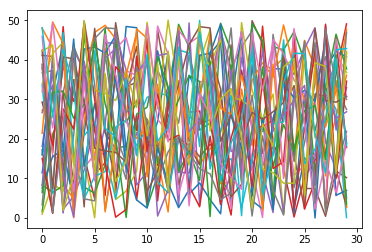

P equivalence: True
P_dist equivalence: True


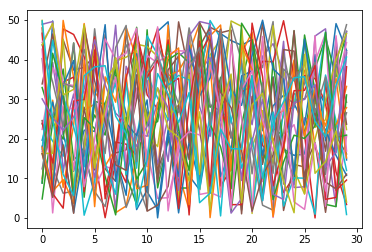

P equivalence: True
P_dist equivalence: True


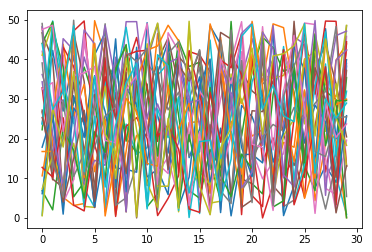

P equivalence: True
P_dist equivalence: True


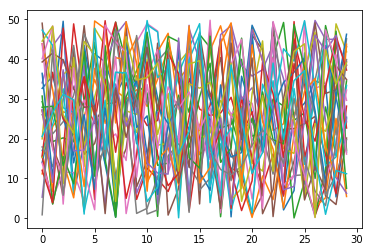

P equivalence: True
P_dist equivalence: True


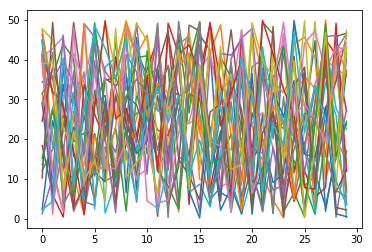

P equivalence: True
P_dist equivalence: True


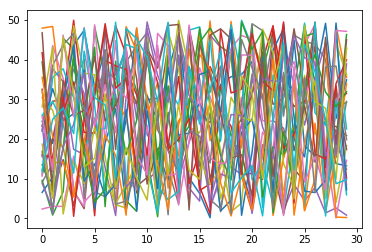

P equivalence: True
P_dist equivalence: True


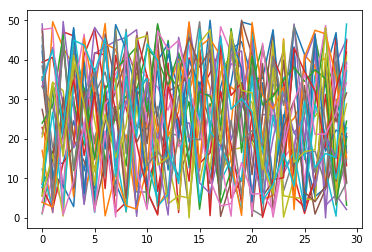

P equivalence: True
P_dist equivalence: True





In [10]:
bad_elec_probs = []
bad_dist_probs = []
for j in range(3):
    proba_case = []
    print "Real Proba Case", j
    for i in range(10):
        proba_case.append(probdata(j))
        x = range(proba_case[i][0].shape[1])
        for k in range(proba_case[i][0].shape[0]):
            plt.plot(x, proba_case[i][0][k,:])
        plt.show()
        P, P_dist = realproba(proba_case[i][0], proba_case[i][1])
        
        # Modify string for MATLAB processing
        test_split = str(proba_case[i][0]).split()
        for k in range(len(test_split)):
            if test_split[k][-1:] == "]":
                test_split[k] = test_split[k] + ";"
            elif test_split[k] != "[[" and test_split[k] != "[":
                test_split[k] = test_split[k] + ","
        newstr = ' '.join(test_split)
        #print newstr
        
        mat_P, mat_P_dist = eng.realproba(
            eng.eval(newstr), float(proba_case[i][1]), stdout = out, nargout = 2)
    #     print "MATLAB Data Norm:"
    #     print out.getvalue()
        print "P equivalence:", eval_proba(P, np.array(mat_P))
        if not eval_proba(P, np.array(mat_P)):
            bad_elec_probs.append((j, i))
    #     print "Python"
    #     print P
    #     print "MATLAB"
    #     print np.array(mat_P)
    #     print "P_dist"
    #     print P_dist
    #     print "Data"
    #     print proba_case1[i][0]
        print "P_dist equivalence:", eval_proba(P_dist, mat_P_dist)
        if not eval_proba(P_dist, mat_P_dist):
            bad_dist_probs.append((j,i))
    print
    print
    print

In [11]:
print bad_elec_probs
print bad_dist_probs
print "HOORAY!"

[]
[]
HOORAY!


**Now, will run on real data!**

In [12]:
import h5py
import os
# os.chdir("/home/nitin/hopkins/neurodata/nicolas")

# return tuple of patient info
def get_patient(filename):
    curr_wd = os.getcwd()
    os.chdir("/home/nitin/hopkins/neurodata/nicolas")
    elec_range = range(0, 110)
    # get data
    D = h5py.File(filename, 'r')
    patient = D["EEG"]["data"][:, :]
    time = D["EEG"]["times"][:]
    nic_auto_bad = D["auto_badchans"][:]
    nic_man_bad = D["man_badchans"][:]
    # get zero elecs
    zero_elec = []
    for i in range(patient.shape[1]):
        is_zero = True
        for j in range(500):
            if patient[j, i] != 0:
                is_zero = False
        if is_zero:
            zero_elec.append(i)
    
    # make it 0-indexed
    nic_auto_bad = [int(x) - 1 for x in nic_auto_bad if x != 0]
    nic_man_bad = [int(x) - 1 for x in nic_man_bad if x != 0]
    # get good electrodes
    good_elec = set(elec_range).difference(nic_auto_bad).difference(nic_man_bad).difference(zero_elec)
    os.chdir(curr_wd)
    return patient, time, nic_auto_bad, nic_man_bad, zero_elec, good_elec


In [13]:
# patient0 = gp_A00051826001.mat
patient0 = get_patient("gp_A00051826001.mat")

# define function to segregate data into separate trials
def trials(l, n):
    print l.shape[0]
    print l.shape[1]
    num = len(l)/n
    print num * n
    l = l[:(num * n),:]
    ret_arr = np.reshape(l, (n, len(l)/n, l.shape[1]))
    ret_arr = np.rollaxis(ret_arr, 2)
    return ret_arr

patient0_trials = trials(patient0[0], 4)
print patient0_trials.shape

def to_matlab_comp(mat):
    scipy.io.savemat('notes/bad_chan_detect/temp/test.mat', mdict = {"arr":mat})
    loaded_mat = eng.load(os.getcwd() + '/notes/bad_chan_detect/temp/test.mat')
    data = eng.double(loaded_mat.values()[0])
    return data

209026
111
209024
(111, 4, 52256)


In [14]:
os.chdir("/home/nitin/hopkins/neurodata/orange-panda")
test_mat, test_bins = probdata(0)
# print test_mat
scipy.io.savemat('notes/bad_chan_detect/temp/test.mat', mdict = {"arr":test_mat})
test_load_mat = eng.load(os.getcwd() + '/notes/bad_chan_detect/temp/test.mat')
# print test_load_mat.values()[0]
data = eng.double(test_load_mat.values()[0]) # d is for double, see link below on types
# print data
test_prob, test_dist = realproba(test_mat, test_bins)
mat_prob, mat_dist = eng.realproba(data, eng.double(int(test_bins)), stdout = out, nargout = 2)
print test_prob
print
print
print mat_prob
print eval_proba(test_prob, mat_prob)

[[ 0.0625  0.125   0.0625  0.0625]
 [ 0.0625  0.0625  0.0625  0.0625]
 [ 0.0625  0.125   0.0625  0.0625]
 [ 0.0625  0.0625  0.0625  0.0625]]


[[0.0625,0.125,0.0625,0.0625],[0.0625,0.0625,0.0625,0.0625],[0.0625,0.125,0.0625,0.0625],[0.0625,0.0625,0.0625,0.0625]]
True


/home/nitin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:77: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/nitin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:78: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [15]:
print patient0_trials.shape
# get 1 electrode
patient0_1 = patient0_trials[1,:,:]
print patient0_1.shape
# get matlab version
pat0_1_mat = to_matlab_comp(patient0_1)
print type(pat0_1_mat)
# now run both
prob_1, dist_1 = realproba(patient0_1, 1000)
mat_prob_1, mat_dist_1 = eng.realproba(pat0_1_mat, 1000.0, stdout = out, nargout = 2)

(111, 4, 52256)
(4, 52256)
<class 'matlab.mlarray.double'>


In [16]:
# print prob_1[0,:].shape
# print np.asarray(mat_prob_1)[0,:].shape
prob_diff = prob_1[0,:] - np.asarray(mat_prob_1)[0,:]
prob_non_diff = np.nonzero(prob_diff)[0]
print "Nonzero Difference:", prob_non_diff
print "Amount of nonzero difference:", len(prob_non_diff)
print 56
print prob_1[0,56]
print np.asarray(mat_prob_1)[0,56]
print prob_diff[56]
print 51989
print prob_1[0,51989]
print np.asarray(mat_prob_1)[0,51989]
print prob_diff[51989]
print 76
print prob_1[0,76]
print np.asarray(mat_prob_1)[0,76]
print prob_diff[76]

diff_err = []
same_err = []
for i in prob_non_diff:
    if np.isclose(abs(prob_diff[i]), prob_diff[56], atol=1e-10):
        same_err.append(i)
    else:
        diff_err.append(i)
print "Diff:", len(diff_err)
print "Same:", len(same_err)
print prob_diff[diff_err]


# print eval_proba(prob_1[0,:], np.asarray(mat_prob_1)[0,:])
print eval_proba(dist_1[0,:], np.asarray(mat_dist_1)[0,:])

Nonzero Difference: [   56    76   180 ..., 51989 52167 52222]
Amount of nonzero difference: 1400
56
0.00440619259032
0.0044014084507
4.78413962033e-06
51989
0.00440619259032
0.0044014084507
4.78413962033e-06
76
0.00449230710349
0.00449709124311
-4.78413962033e-06
Diff: 2
Same: 1398
[  1.48308328e-04   9.08986528e-05]
False


In [17]:
prob_diff = prob_1[1,:] - np.asarray(mat_prob_1)[1,:]
prob_non_diff = np.nonzero(prob_diff)[0]
print "Nonzero Difference:", prob_non_diff
print "Amount of nonzero difference:", len(prob_non_diff)
print 62
print prob_1[1,62]
print np.asarray(mat_prob_1)[1,62]
print prob_diff[62]
print 52141
print prob_1[1,52141]
print np.asarray(mat_prob_1)[1,52141]
print prob_diff[52141]
print 76
print prob_1[1,92]
print np.asarray(mat_prob_1)[1,92]
print prob_diff[92]

diff_err = []
same_err = []
for i in prob_non_diff:
    if np.isclose(abs(prob_diff[i]), abs(prob_diff[62]), atol=1e-10):
        same_err.append(i)
    else:
        diff_err.append(i)
print "Diff:", len(diff_err)
print "Same:", len(same_err)
print prob_diff[diff_err]


# print eval_proba(prob_1[0,:], np.asarray(mat_prob_1)[0,:])

Nonzero Difference: [   62    92   120 ..., 52141 52179 52242]
Amount of nonzero difference: 1396
62
0.00425310012247
0.00425788426209
-4.78413962033e-06
52141
0.00268390232701
0.00267911818739
4.78413962033e-06
76
0.00425310012247
0.00425788426209
-4.78413962033e-06
Diff: 1
Same: 1395
[-0.00012917]


In [18]:
# Will see if thresholding gets messed up
# because of the slight differences
pat0_test = patient0_trials[1:4,:,:]
pat0_test_mat = to_matlab_comp(pat0_test)
print pat0_test.shape
print np.asarray(pat0_test_mat).shape

(3, 4, 52256)
(3, 4, 52256)


In [19]:
# now run both test sets, collect joint probs
py_prob = []
mat_prob = []
for i in range(pat0_test.shape[0]):
    py_prob.append(np.log(realproba(pat0_test[i,:,:], 1000)[0]))
    mat_prob.append(np.log(eng.realproba(to_matlab_comp(pat0_test[i,:,:]), 1000.0, stdout = out, nargout = 1)))

py_prob = np.asarray(py_prob)
mat_prob = np.asarray(mat_prob)

py_prob = -np.sum(py_prob, axis=2)
mat_prob = -np.sum(mat_prob, axis=2)
print py_prob.shape
print mat_prob.shape

(3, 4)
(3, 4)


In [20]:
print py_prob
print
print mat_prob

[[ 310865.95212944  308781.64578643  310840.63345638  312534.99150142]
 [ 302038.07471765  302299.76778987  305478.72305481  305894.00647584]
 [ 298638.88472098  298492.64045249  301894.08500642  302506.99140885]]

[[ 310865.92014217  308781.5597163   310840.72548168  312535.11306153]
 [ 302038.16509743  302299.7194412   305478.48935733  305894.0428437 ]
 [ 298638.79181995  298492.80161353  301894.0757224   302506.96115188]]


In [21]:
py_mean = np.mean(py_prob, axis=1, keepdims=True)
py_std = np.std(py_prob, axis=1, keepdims=True)
test_ones = np.ones(py_prob.shape)
py_norm = np.divide(py_prob - py_mean * test_ones, py_std)
print py_norm

[[ 0.08277862 -1.48364553  0.06375081  1.3371161 ]
 [-1.06920577 -0.92112764  0.87767335  1.11266005]
 [-0.95263467 -1.03250632  0.82520038  1.15994061]]


In [22]:
mat_mean = np.mean(mat_prob, axis=1, keepdims=True)
mat_std = np.std(mat_prob, axis=1, keepdims=True)
test_ones = np.ones(mat_prob.shape)
mat_norm = np.divide(mat_prob - mat_mean * test_ones, mat_std)
print mat_norm

[[ 0.08273207 -1.48364636  0.0637985   1.33711579]
 [-1.06916544 -0.92116127  0.87758999  1.11273672]
 [-0.95270503 -1.03243923  0.82520498  1.15993927]]


In [23]:
thresh = np.linspace(1,3,num=21)
py_rej = []
mat_rej = []
diff_rej = []
for i in thresh:
    py_curr = abs(py_norm) > i
    mat_curr = abs(mat_norm) > i
    py_rej.append(py_curr)
    mat_rej.append(mat_curr)
    if not np.array_equal(py_curr, mat_curr):
        diff_rej.append(i)
# print py_rej
# print mat_rej
print diff_rej

[]


In [36]:
# define function to segregate data into separate trials
def trials(l, n):
    num = len(l)/n
    l = l[:(num * n),:]
    ret_arr = np.reshape(l, (n, len(l)/n, l.shape[1]))
    ret_arr = np.rollaxis(ret_arr, 2)
    return ret_arr

patient0_trials = trials(patient0[0], 4)
# patient, zero = list(get_patient("gp_A00051826001.mat")[i] for i in [0, 4])

In [33]:
def compare_data_help(data):
    # set bins
    bins = 1000
    # get joint probs
    py_prob = []
    mat_prob = []
    for i in range(data.shape[0]):
        py_prob.append(realproba(data[i,:,:], bins)[0])
        mat_prob.append(eng.realproba(to_matlab_comp(data[i,:,:]), eng.double(int(bins)), stdout = out, nargout = 1))
    print "Python realproba executed"
    py_prob = np.asarray(py_prob)
    print py_prob.shape
    print "MATLAB realproba executed"
    mat_prob = np.asarray(mat_prob)
    print mat_prob.shape
    # now run both test sets, collect joint probs with log transform
    py_prob = np.log(py_prob)
    mat_prob = np.log(mat_prob)
    print "Data log transformed"
    # sum logs of likelihoods
    py_prob = -np.sum(py_prob, axis=2)
    mat_prob = -np.sum(mat_prob, axis=2)
    print "Logs summed"
    print py_prob
    print
    print mat_prob
    # normalize data
    test_ones = np.ones(py_prob.shape)
    py_mean = np.mean(py_prob, axis=1, keepdims=True)
    py_std = np.std(py_prob, axis=1, keepdims=True)
    py_norm = np.divide(py_prob - py_mean * test_ones, py_std)
    mat_mean = np.mean(mat_prob, axis=1, keepdims=True)
    mat_std = np.std(mat_prob, axis=1, keepdims=True)
    mat_norm = np.divide(mat_prob - mat_mean * test_ones, mat_std)
    print "Data normed"
    print py_norm
    print
    print mat_norm
    # threshold data
    thresh = np.linspace(1,3,num=21)
    py_rej = []
    mat_rej = []
    diff_rej = []
    for i in thresh:
        py_curr = abs(py_norm) > i
        mat_curr = abs(mat_norm) > i
        py_rej.append(py_curr)
        mat_rej.append(mat_curr)
        if not np.array_equal(py_curr, mat_curr):
            diff_rej.append(i)
    return py_rej, mat_rej, diff_rej

In [35]:
# reshape data with trials
num_trials = 4
data = trials(patient0[0], num_trials)
data = data[1:4,:,:]
py_orig, mat_orig, diff_orig = compare_data_help(data)

Python realproba executed
(3, 4, 52256)
MATLAB realproba executed
(3, 4, 52256)
Data log transformed
Logs summed
[[ 310865.95212944  308781.64578643  310840.63345638  312534.99150142]
 [ 302038.07471765  302299.76778987  305478.72305481  305894.00647584]
 [ 298638.88472098  298492.64045249  301894.08500642  302506.99140885]]

[[ 310865.92014217  308781.5597163   310840.72548168  312535.11306153]
 [ 302038.16509743  302299.7194412   305478.48935733  305894.0428437 ]
 [ 298638.79181995  298492.80161353  301894.0757224   302506.96115188]]
Data normed
[[ 0.08277862 -1.48364553  0.06375081  1.3371161 ]
 [-1.06920577 -0.92112764  0.87767335  1.11266005]
 [-0.95263467 -1.03250632  0.82520038  1.15994061]]

[[ 0.08273207 -1.48364636  0.0637985   1.33711579]
 [-1.06916544 -0.92116127  0.87758999  1.11273672]
 [-0.95270503 -1.03243923  0.82520498  1.15993927]]


In [37]:
def compare_data(filename):
    # set dir
    curr_dir = os.getcwd()
    os.chdir("/home/nitin/hopkins/neurodata/orange-panda")
    print "Set dir"
    # get patient data
    patient, zero = list(get_patient(filename)[i] for i in [0, 4])
    print "Have patient data"
    # get rid of 0 electrodes
    data = patient[:, list(set(range(111)) - set(zero))]
    print "Removed 0's"
    # reshape data with trials
    num_trials = 4
    data = trials(data, num_trials)
    print "Gotten trials"
    return compare_data_help(data)

In [38]:
py_test, mat_test, diff_test = compare_data("gp_A00051826001.mat")

Set dir
Have patient data
Removed 0's
Gotten trials
Python realproba executed
(105, 4, 52256)
MATLAB realproba executed
(105, 4, 52256)
Data log transformed
Logs summed
[[ 310865.95212944  308781.64578643  310840.63345638  312534.99150142]
 [ 302038.07471765  302299.76778987  305478.72305481  305894.00647584]
 [ 298638.88472098  298492.64045249  301894.08500642  302506.99140885]
 [ 294925.40176394  290821.90331738  292832.2660421   298779.41958625]
 [ 295590.2353898   294492.794345    297267.14573771  299762.80690988]
 [ 294676.89960677  290258.30316868  293117.1869209   297504.6325163 ]
 [ 298109.47066503  296640.00755616  300369.57682086  301407.64562379]
 [ 298933.5905598   296820.03165179  301957.4574293   301418.47596317]
 [ 299606.54090631  298058.94863954  302906.15360951  302339.68474571]
 [ 296286.28556735  293788.21589414  297397.28994239  300041.30486299]
 [ 294580.09723625  290594.84896623  294134.06231915  298821.73036273]
 [ 298078.43535174  295463.40181758  299006.386337

In [39]:
print diff_test

[]


In [41]:
# List all patient names
patient_names = [
    "bip_A00053375001",
    "gip_A00051955001",
    "gip_A00053440001"
]

In [42]:
diff_fin = []
for name in patient_names:
    print name
    py_rej, mat_rej, diff_rej = compare_data(name + ".mat")
    if diff_rej:
        diff_fin.append((name, py_rej, mat_rej, diff_rej))
    print

bip_A00053375001
Set dir
Have patient data
Removed 0's
Gotten trials
Python realproba executed
(108, 4, 32837)
MATLAB realproba executed
(108, 4, 32837)
Data log transformed
Logs summed
[[ 183946.24799358  185079.15476356  187161.45169744  185470.53866515]
 [ 184972.81841615  185595.40646515  188129.4875894   186072.53853958]
 [ 184797.00059687  185540.37309732  188084.60038114  186086.18392126]
 [ 189541.58224458  189496.58585317  192262.04443607  191142.37705071]
 [ 192078.06787796  191107.17094836  193309.75336308  191937.79531145]
 [ 186901.78575574  186699.89377567  188227.7470184   187801.29705585]
 [ 191512.05195382  193371.4842115   192097.76452351  193112.34271701]
 [ 184718.73330651  185587.55228336  188049.26702174  186507.60858421]
 [ 190439.90601509  191333.66498554  193010.47052343  191968.80246188]
 [ 189072.88479063  188143.01483024  190871.22914105  189572.5698335 ]
 [ 187663.16683078  187008.15214119  188443.32043919  188174.59414674]
 [ 200923.15609223  201522.742789

In [44]:
print diff_fin

[]


Based off of these 4 patients, this should work. Will test further with the jointprob and pop_jointprob implementations.

***
### To check jointprob and pop_jointprob

**For all sine waves created:** make sure number of points = 1000 sampled from each wave representing data.

***Success:***
- 50 sine waves, all same frequency but different amplitudes
    - Should result in none selected
- 50 sine waves, different frequency all same amplitudes
    - Should result in none selected
- 50 sine waves, all same frequency but different amplitudes, 1 with lots of white noise
    - Should result in white noise one selected
- 50 sine waves, all different frequency but same amplitudes, 1 with lots of white noise
    - Should result in white noise one selected
- 50 sine waves, all same frequency but different amplitudes, 6-7 with white noise
    - Should result in white noise one selected

***Hopeful:***
- 40 sine waves, 32 with slight noise, 8 with heavy noise **CLOSEST TO REAL DATA**

***Fail:***
- 50 sine waves, all same frequency but different amplitudes, 40 with white noise
    - No idea result; either none selected or multiple


In [283]:
# Write next level wrapper, jointprob
# Joint prob can use different prob functions to get the distribution
# S = C x T x N, channels x trials x timepoints, numpy array
# OR
# S = N x (C x T), timepoints x (channels x trials), numpy array
# OR
# S = (N x C x T), straight vector of all timepoints, numpy array
# thresholds
# norm = choose normalization: 0 = none, 1 = normalize entropy, 2 = 20% trim
# thresh = threshold
def jointprob(S, thresh, oldjp, normalize, discret = 1000):
    # get num chans and trials and time
    channels = 0
    trials = 0
    timepts = 0
    if S.ndim == 1 or S.ndim == 2:
        timepts = S.shape[0]
    elif S.ndim == 3:
        channels = S.shape[0]
        trials = S.shape[1]
        timepts = S.shape[2]
    else:
        print "Bad dimensions"
        return
    # Get Joint Probs
    jp = np.zeros((channels, trials))
    if oldjp.size:
        jp = oldjp
    else:
        jp = []
        for c in range(channels):
            tmp, dist = realproba(S[c,:,:], discret)
            jp.append(np.log(tmp))
        jp = np.asarray(jp)
        jp = -np.sum(jp, axis=2)    
#     print jp
    unnormjp = jp
    # Normalize data
    if normalize:
        tmpjp = jp
        if normalize == 2:
            tmpjp = sort(jp);
            totrim = round(len(tmpjp) * 0.1)
            tmpjp = tmpjp[totrim : -totrim]
        if S.ndim == 2:
            jp = (jp - np.mean(tmpjp)) / np.std(tmpjp)
        elif S.ndim == 3:
            ones = np.ones(jp.shape)
            mean = np.mean(jp, axis=1, keepdims=True)
            std = np.std(jp, axis=1, keepdims=True)
#             print jp
#             print mean
#             print std
            jp = np.divide(jp - mean * ones, std)
    # Reject bad elecs
    rej = []
    for i in thresh:
#         print abs(jp) > i
        rej.append(abs(jp) > i)
    return jp, np.asarray(rej), unnormjp

In [298]:
# Then define the general sine wave used throughout
def get_sin(chans, trials, tovary = 0):
    numvals = 1000
    # First, build the relevant linspace to grab 1000 points
    times = np.linspace(0, 1, numvals)
    wave = np.zeros((chans, trials, numvals))
    for i in range(chans):
        if tovary == 0:
            wave[i,:,:] = [np.random.uniform(.1, 6) * np.sin(2 * np.pi * times)] * trials
        elif tovary == 1:
            wave[i,:,:] = [np.sin(np.random.uniform(.1, 6) * 2 * np.pi * times)] * trials
        else:
            wave[i,:,:] = [np.random.uniform(.1, 6) * np.sin(np.random.uniform(.1, 6) * 2 * np.pi * times)] * trials
    return wave

# Define function for white noise
def gen_whitenoise(mean, std, size):
    retval = np.random.normal(mean, std, size=size)
    return retval

# Success Case 1 Data
# 50 sine waves, all same frequency but different amplitudes
def success1():
    bins = np.floor(np.random.uniform(15, 25))
    return get_sin(50, 10, 0), bins, []

# Success Case 2 Data
# 50 sine waves, different frequency all same amplitudes
def success2():
    bins = np.floor(np.random.uniform(15, 25))
    return get_sin(50, 10, 1), bins, []

# Success Case 3 Data
# 50 sine waves, all same frequency but different amplitudes, 1 with white noise
def success3():
    num_chans = 50
    num_trials = 10
    bins = np.floor(np.random.uniform(15, 25))
    bad_wn = []
    for i in range(num_trials):
        bad_wn.append(gen_whitenoise(0, 8, 1000))
    reg_wn = []
    for i in range(num_trials):
        reg_wn.append(gen_whitenoise(0, 1, 1000))
    badelec = np.floor(np.random.uniform(0, 50))
    toret = get_sin(num_chans, num_trials, 0)
    for i in range(num_chans):
        if i == badelec:
            toret[i, :] = toret[i, :] + bad_wn[:]
        else:
            toret[i, :] = toret[i, :] + reg_wn[:]
    return toret, bins, [badelec]
#print success2[0]

# # Success Case 3 Data
# # 50 different amplitude sine waves, 1 with white noise
# success3 = np.column_stack([sin] * 10 +
#                            [sin * 2] * 10 +
#                            [sin * 3] * 10 +
#                            [sin * 4] * 10 +
#                            [sin * 5] * 10)
# success3[:, 49] = success3[:, 49] + wn.T

(50, 10, 1000)


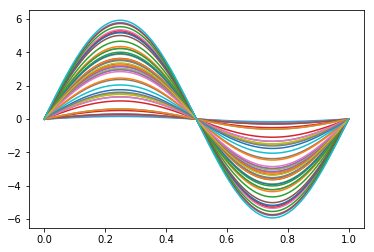

(50, 10, 1000)


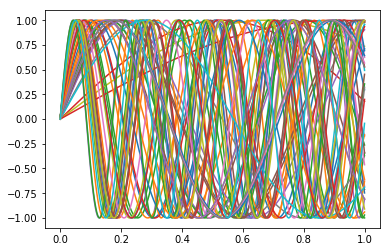

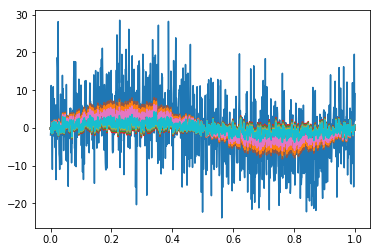

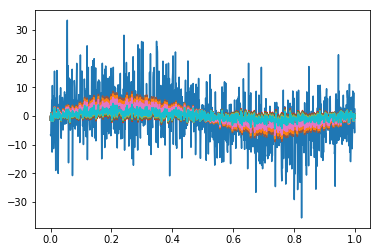

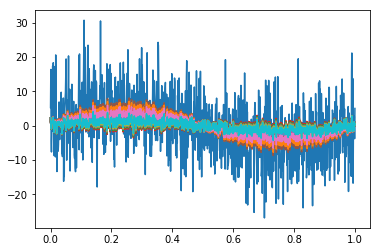

In [299]:
test_dat = success1()
print test_dat[0].shape
for i in range(50):
    plt.plot(np.linspace(0,1,1000), test_dat[0][i,0,:])
plt.show()
test_dat = success2()
print test_dat[0].shape
for i in range(50):
    plt.plot(np.linspace(0,1,1000), test_dat[0][i,0,:])
plt.show()
test_dat = success3()
for j in range(3):
    for i in range(50):
        plt.plot(np.linspace(0,1,1000), test_dat[0][i,j,:])
    plt.show()

In [145]:
# test_jp is the jp for the test data currently using
jp, rej = jointprob(patient0_trials[1:4,:,:], [1, 1.5, 2, 2.5, 3], np.asarray([]), 1000)

In [146]:
print jp
print rej

[[ 0.08277862 -1.48364553  0.06375081  1.3371161 ]
 [-1.06920577 -0.92112764  0.87767335  1.11266005]
 [-0.95263467 -1.03250632  0.82520038  1.15994061]]
[[0, 1, 2] [] [] [] []]


In [203]:
test_dat = success1()

In [215]:
out = StringIO.StringIO()
mat_test_dat = np.swapaxes(test_dat[0], 1, 2)
mat_jp, mat_rej = eng.jointprob(to_matlab_comp(mat_test_dat), 1, [], 1, 1000.0, nargout = 2, stdout = out)

In [216]:
print out.getvalue()
print np.asarray(mat_jp).shape
print mat_jp

    50

        1000

        1000

        1000

        1000

        1000

        1000

        1000

        1000

        1000

        1000

        1000

        1000

        1000

        1000

        1000

        1000

        1000

        1000

        1000

        1000

        1000

        1000

        1000

        1000

        1000

        1000

        1000

        1000

        1000

        1000

        1000

        1000

        1000

        1000

        1000

        1000

        1000

        1000

        1000

        1000

        1000

        1000

        1000

        1000

        1000

        1000

        1000

        1000

        1000

        1000

   1.0e+03 *

  Columns 1 through 7

    6.4981    6.4981    6.4981    6.4981    6.4981    6.4981    6.4981
    6.4981    6.4981    6.4981    6.4981    6.4981    6.4981    6.4981
    6.4981    6.4981    6.4981    6.4981    6.4981    6.4981    6.4981
    6.4981    6.4981    6.4981    6.4981  

In [225]:
py_jp, py_rej = jointprob(test_dat[0], [1], np.asarray([]), 1, 1000)

[[ 6498.12684141  6498.12684141  6498.12684141  6498.12684141
   6498.12684141  6498.12684141  6498.12684141  6498.12684141
   6498.12684141  6498.12684141]
 [ 6498.12684141  6498.12684141  6498.12684141  6498.12684141
   6498.12684141  6498.12684141  6498.12684141  6498.12684141
   6498.12684141  6498.12684141]
 [ 6498.12684141  6498.12684141  6498.12684141  6498.12684141
   6498.12684141  6498.12684141  6498.12684141  6498.12684141
   6498.12684141  6498.12684141]
 [ 6498.12684141  6498.12684141  6498.12684141  6498.12684141
   6498.12684141  6498.12684141  6498.12684141  6498.12684141
   6498.12684141  6498.12684141]
 [ 6498.12684141  6498.12684141  6498.12684141  6498.12684141
   6498.12684141  6498.12684141  6498.12684141  6498.12684141
   6498.12684141  6498.12684141]
 [ 6498.12684141  6498.12684141  6498.12684141  6498.12684141
   6498.12684141  6498.12684141  6498.12684141  6498.12684141
   6498.12684141  6498.12684141]
 [ 6498.12684141  6498.12684141  6498.12684141  6498.12684

In [304]:
# print py_jp

In [233]:
mat_rej = np.asarray(mat_rej)
print mat_rej.shape
print py_rej.shape
print np.any(mat_rej)
print np.any(py_rej)

(50, 10)
(1, 50, 10)
False
False


**Now, while we now know that the resulting MATLAB one should always be NAN and python should 1 or -1 (both indicative of issues anyways) because the std is tiny because the data values are all predictable and perfect, we can check for that behavior for consistency.**

In [236]:
test_dat = success2()
mat_test_dat = np.swapaxes(test_dat[0], 1, 2)
mat_jp, mat_rej = eng.jointprob(to_matlab_comp(mat_test_dat), 1, [], 1, 1000.0, nargout = 2, stdout = out)
py_jp, py_rej = jointprob(test_dat[0], [1], np.asarray([]), 1, 1000)
mat_jp = np.asarray(mat_jp)
mat_rej = np.asarray(mat_rej)

/home/nitin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:53: RuntimeWarning: invalid value encountered in divide
/home/nitin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:58: RuntimeWarning: invalid value encountered in greater


In [248]:
print py_jp.shape == mat_jp.shape
print py_jp[0:5,:]
print mat_jp[0:5,:]
print np.all(np.isclose(py_jp, mat_jp, atol=.1, equal_nan=True))

True
[[ -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.]]
[[-0.9486833 -0.9486833 -0.9486833 -0.9486833 -0.9486833 -0.9486833
  -0.9486833 -0.9486833 -0.9486833 -0.9486833]
 [ 0.9486833  0.9486833  0.9486833  0.9486833  0.9486833  0.9486833
   0.9486833  0.9486833  0.9486833  0.9486833]
 [       nan        nan        nan        nan        nan        nan
         nan        nan        nan        nan]
 [-0.9486833 -0.9486833 -0.9486833 -0.9486833 -0.9486833 -0.9486833
  -0.9486833 -0.9486833 -0.9486833 -0.9486833]
 [ 0.9486833  0.9486833  0.9486833  0.9486833  0.9486833  0.9486833
   0.9486833  0.9486833  0.9486833  0.9486833]]
False


In [272]:
print out.getvalue()

Same issue... :(

In [300]:
out = StringIO.StringIO()
test_dat = success3()
mat_test_dat = np.swapaxes(test_dat[0], 1, 2)
mat_jp, mat_rej = eng.jointprob(to_matlab_comp(mat_test_dat), 1, [], 1, 1000.0, nargout = 2, stdout = out)
py_jp, py_rej, py_unnorm = jointprob(test_dat[0], [1], np.asarray([]), 1, 1000)
mat_jp = np.asarray(mat_jp)
mat_rej = np.asarray(mat_rej)

In [309]:
print "Shapes Equal?:", py_jp.shape == mat_jp.shape
print "Python head"
print py_jp[0:5,:]
print "MATLAB Head"
print mat_jp[0:5,:]
print np.all(np.isclose(py_jp, mat_jp, atol=.1, equal_nan=True))
print "MATLAB has any NaNs?:", np.isnan(mat_jp).any()
print "Python vals bad elec"
print py_jp[test_dat[2][0]]
print "MATLAB vals bad elec"
print mat_jp[test_dat[2][0]]
print "Python has any NaNs?:", np.isnan(py_jp).any()
print "Arrays close (.1) tolerance?", np.isclose(py_jp, mat_jp, atol=.1).all()

Shapes Equal?: True
Python head
[[-0.67278324 -0.29723372  0.32573826 -1.76865911  0.26717119  0.1698005
  -1.12611931  0.56355829  2.08066329  0.45786386]
 [-0.51969504 -0.93560201  0.34211322 -1.9803468   1.34191787  1.17704879
  -0.61271622 -0.31540218  0.6381228   0.86455956]
 [-1.09293195 -1.01505466  0.14328488 -1.55733417  1.08597841  1.78319419
  -0.59985055  0.59988021  0.1895957   0.46323795]
 [-0.44095072 -0.98299426  2.24682869 -1.0484713   0.59645993 -0.5475296
  -0.39606436 -0.70199236  1.17312387  0.10159011]
 [ 0.44411117 -1.0525679   0.52465985 -2.52141983  1.09079803  0.68868033
  -0.12096589  0.51995665  0.31795593  0.10879166]]
MATLAB Head
[[-0.63825822 -0.28198067  0.30902245 -1.67789736  0.25346085  0.1610869
  -1.06833059  0.53463833  1.97389051  0.4343678 ]
 [-0.493026   -0.88759     0.3245571  -1.87872193  1.27305507  1.11664653
  -0.58127364 -0.29921678  0.60537644  0.82019321]
 [-1.03684629 -0.9629654   0.13593197 -1.47741692  1.03024958  1.69168654
  -0.5690

/home/nitin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/nitin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [338]:
print np.array_equal(py_rej, mat_rej)
rej_differences = np.logical_xor(py_rej, mat_rej)
rej_locs = np.where(np.any(rej_differences))
print mat_rej[test_dat[2]]
print rej_differences[0][test_dat[2]]
print np.min(abs(py_jp))
# print py_jp - mat_jp

False
[[False  True  True False False False False  True False False]]
[[False False False False False False False False False False]]
0.000432616678757


/home/nitin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
/home/nitin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future


This seems pretty bad tbh. A lot of differences in rejected trials.

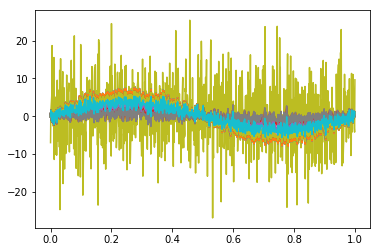

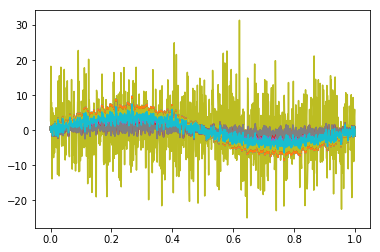

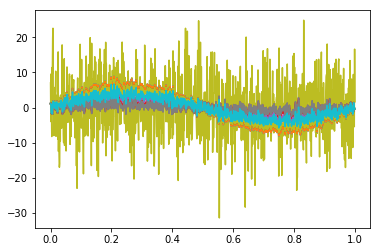

Shapes Equal?: True
Python head
[[-1.9916106   0.76648198 -0.1145623   0.54030201 -0.37611501 -0.49946755
  -0.32966428  1.79797577 -0.7295151   0.93617509]
 [-0.64912651  0.00987118  1.89470723 -0.28648728  0.69950018 -1.40508439
   0.47583133  0.85104904 -0.01160643 -1.57865436]]
MATLAB Head
[[-1.88940771  0.72714865 -0.10868334  0.51257549 -0.35681403 -0.47383652
  -0.312747    1.70570958 -0.69207879  0.88813367]
 [-0.61581548  0.00936463  1.7974771  -0.2717857   0.66360414 -1.3329801
   0.45141323  0.80737601 -0.01101082 -1.49764302]]
False
MATLAB has any NaNs?: False
Python has any NaNs?: False
Arrays close (.1) tolerance?: False
Badelecs recognized the same?: False
All electrode/trial rejections the same?: False


/home/nitin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


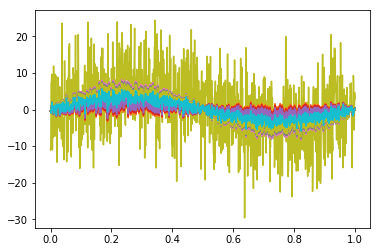

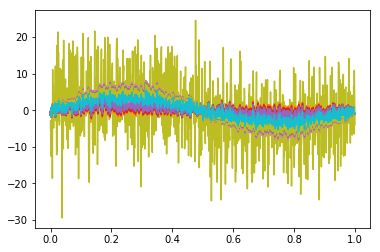

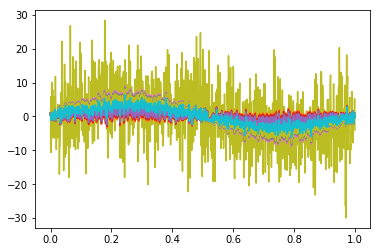

Shapes Equal?: True
Python head
[[-0.39368647 -0.34214067  1.3082404   0.27507899  0.26472609  0.40504336
  -2.00568743 -0.49418635 -0.72460593  1.70721801]
 [ 1.03269604 -0.9335928   0.50146406  1.08484934 -1.04391365  0.88013209
  -1.57659314 -0.06909109 -1.00359197  1.12764113]]
MATLAB Head
[[-0.37348378 -0.32458314  1.24110582  0.26096284  0.25114122  0.38425787
  -1.90276216 -0.46882634 -0.68742154  1.61960921]
 [ 0.97970148 -0.8856839   0.47573058  1.02917845 -0.99034345  0.83496661
  -1.49568758 -0.06554557 -0.95209094  1.06977431]]
False
MATLAB has any NaNs?: False
Python has any NaNs?: False
Arrays close (.1) tolerance?: False
Badelecs recognized the same?: True
All electrode/trial rejections the same?: False


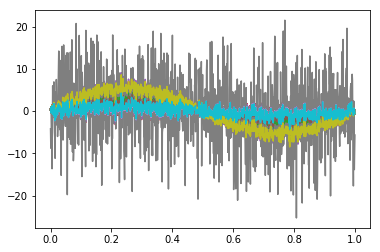

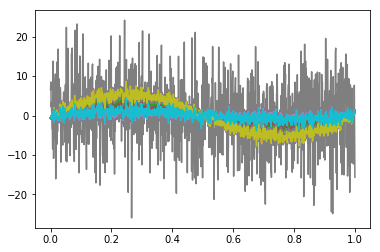

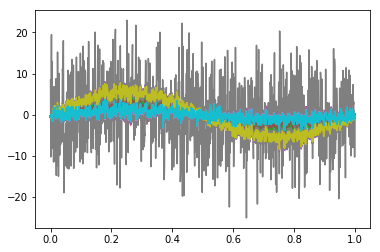

Shapes Equal?: True
Python head
[[-0.79341574 -0.84105359  1.02606759 -1.56243297  1.26059742 -1.01099953
  -0.53810677  0.82029857  0.4644169   1.17462813]
 [ 1.36653468 -0.63815621  0.74238612 -1.92952333  0.4916434  -0.1461001
  -1.506285    0.56506482  0.37893817  0.67549746]]
MATLAB Head
[[-0.75270026 -0.79789349  0.97341319 -1.48225407  1.19590771 -0.95911837
  -0.5104929   0.77820355  0.44058456  1.11435009]
 [ 1.29640863 -0.60540814  0.70428931 -1.83050656  0.46641388 -0.13860272
  -1.42898742  0.53606755  0.35949231  0.64083316]]
False
MATLAB has any NaNs?: False
Python has any NaNs?: False
Arrays close (.1) tolerance?: False
Badelecs recognized the same?: False
All electrode/trial rejections the same?: False


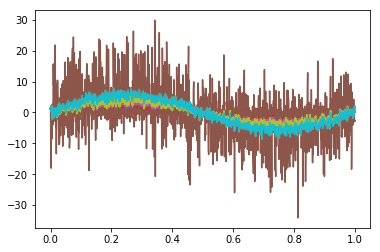

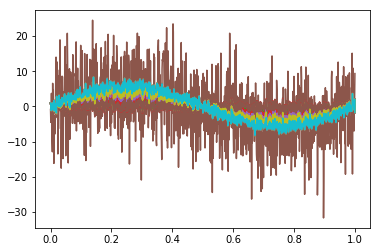

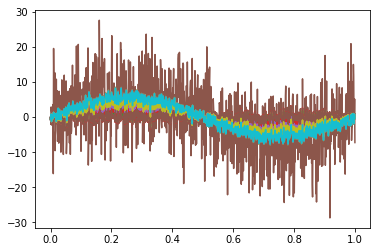

Shapes Equal?: True
Python head
[[ 0.74127008  1.05941708 -0.54933236  0.69338667  0.42652444 -1.53464726
   0.2897052   1.15869246 -0.44558971 -1.83942659]
 [ 0.47262462  2.50659278 -0.22522334 -0.36000972 -0.09854807 -0.29767408
  -0.1823717  -0.32910953  0.2490481  -1.73532907]]
MATLAB Head
[[ 0.70323054  1.00505129 -0.52114244  0.65780435  0.40463662 -1.45589422
   0.27483848  1.09923218 -0.42272352 -1.74503329]
 [ 0.44837108  2.37796271 -0.21366562 -0.34153521 -0.0934909  -0.28239843
  -0.17301298 -0.31222072  0.23626778 -1.6462777 ]]
False
MATLAB has any NaNs?: False
Python has any NaNs?: False
Arrays close (.1) tolerance?: False
Badelecs recognized the same?: False
All electrode/trial rejections the same?: False


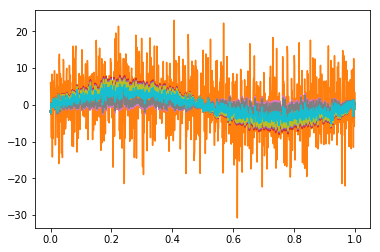

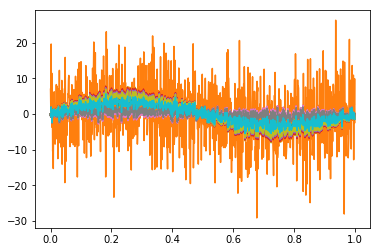

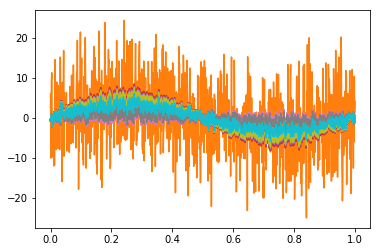

Shapes Equal?: True
Python head
[[ 1.52085364 -0.79961295  0.40957858 -0.06414816  0.74574189 -0.72518563
   0.04757228 -2.25851053  0.38976154  0.73394933]
 [ 1.35372463 -0.34529161  0.50261235 -0.97434484  0.53066977 -1.2022996
   0.49604153 -1.53444244 -0.36993797  1.54326818]]
MATLAB Head
[[ 1.44280844 -0.75857945  0.38856036 -0.06085628  0.70747288 -0.68797149
   0.04513103 -2.14261121  0.36976026  0.69628547]
 [ 1.28425595 -0.32757239  0.47681994 -0.92434468  0.50343755 -1.14060155
   0.47058631 -1.45569991 -0.35095397  1.46407275]]
False
MATLAB has any NaNs?: False
Python has any NaNs?: False
Arrays close (.1) tolerance?: False
Badelecs recognized the same?: True
All electrode/trial rejections the same?: False


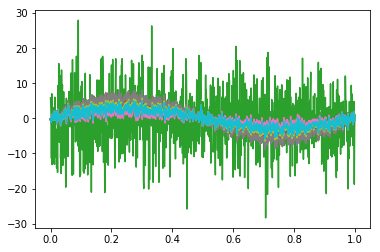

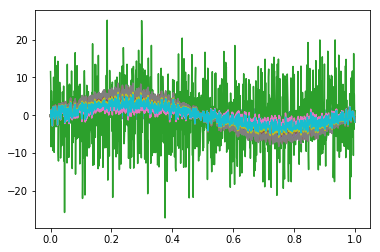

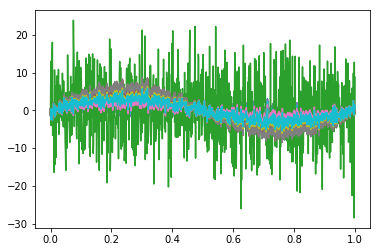

Shapes Equal?: True
Python head
[[ 1.34504749  0.45088173 -0.57136798 -0.84097705  0.97957585  0.84545366
  -1.53963827  1.08169469 -1.19667293 -0.55399719]
 [ 1.31585052 -0.77764277  2.28082356  0.18306845 -0.28796857 -0.04079996
  -1.17664684 -0.60819186 -0.75605052 -0.13244203]]
MATLAB Head
[[ 1.27602409  0.42774397 -0.54204726 -0.79782089  0.92930725  0.80206777
  -1.46062911  1.02618569 -1.13526362 -0.52556788]
 [ 1.24832542 -0.73773671  2.16377922  0.17367398 -0.27319097 -0.03870624
  -1.1162652  -0.57698146 -0.7172525  -0.12564554]]
False
MATLAB has any NaNs?: False
Python has any NaNs?: False
Arrays close (.1) tolerance?: False
Badelecs recognized the same?: True
All electrode/trial rejections the same?: False


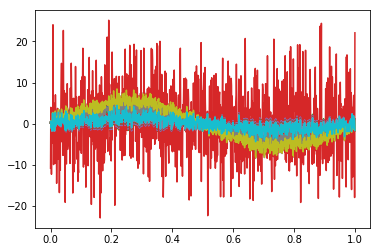

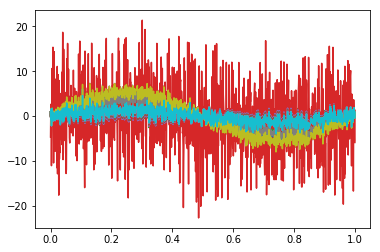

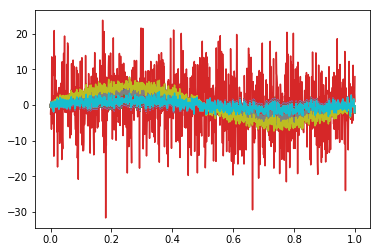

Shapes Equal?: True
Python head
[[ 1.67232942 -1.04420984 -1.59539255 -0.26588033  0.05709005  0.38316369
   1.07838217 -0.6920207   1.10395194 -0.69741383]
 [ 1.20068726  0.41607316 -2.49938332 -0.33415068  0.75318913  0.38432317
   0.39417035 -0.09639559  0.640118   -0.85863147]]
MATLAB Head
[[ 1.58651099 -0.99062443 -1.51352227 -0.25223623  0.05416037  0.36350099
   1.02304315 -0.65650848  1.04730077 -0.66162485]
 [ 1.13907195  0.39472166 -2.37112321 -0.31700317  0.71453795  0.36460097
   0.37394283 -0.09144889  0.60726925 -0.81456934]]
False
MATLAB has any NaNs?: False
Python has any NaNs?: False
Arrays close (.1) tolerance?: False
Badelecs recognized the same?: False
All electrode/trial rejections the same?: False


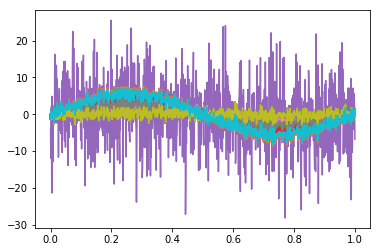

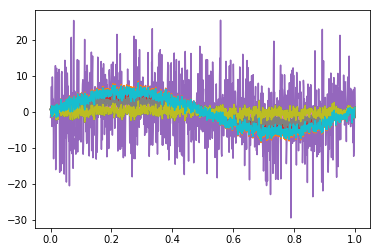

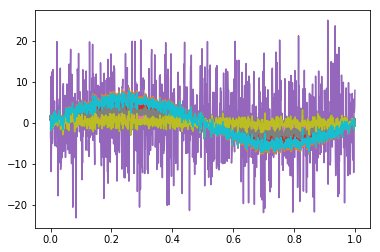

Shapes Equal?: True
Python head
[[-0.62460604  0.39552906 -0.30029051  0.30678165  1.19789442  1.32839714
  -0.43231843 -1.10047486 -1.86438278  1.09347035]
 [-0.23703827  1.42610609 -0.03635298 -2.02583165  0.79066135  1.17896873
   0.63946534 -0.1483333  -1.01560943 -0.57203588]]
MATLAB Head
[[-0.59255331  0.37523181 -0.28488059  0.29103862  1.13642243  1.26022818
  -0.41013328 -1.04400212 -1.7687088   1.03735705]
 [-0.22487425  1.35292303 -0.03448746 -1.92187265  0.75008721  1.11846794
   0.60665009 -0.14072132 -0.9634917  -0.54268089]]
False
MATLAB has any NaNs?: False
Python has any NaNs?: False
Arrays close (.1) tolerance?: False
Badelecs recognized the same?: True
All electrode/trial rejections the same?: False


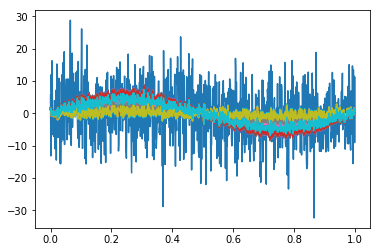

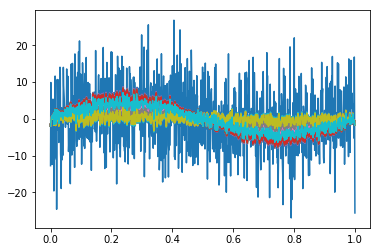

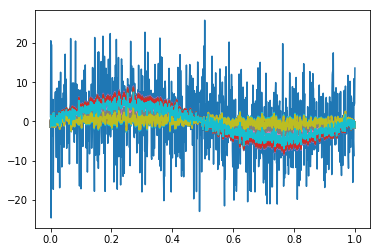

Shapes Equal?: True
Python head
[[ 1.3005304  -0.89840955 -2.03858603  0.96325065  0.36213597  0.13097354
   0.92730763 -0.4489807   0.61363027 -0.91185219]
 [ 0.24914622 -2.45227733 -0.8525847   0.05491463 -0.11801893 -0.03245962
   0.48292694  0.39670642  1.4587633   0.81288307]]
MATLAB Head
[[ 1.23379147 -0.85230614 -1.93397252  0.9138198   0.34355235  0.12425241
   0.87972126 -0.42594049  0.58214079 -0.86505894]
 [ 0.23636086 -2.32643455 -0.80883286  0.05209659 -0.11196259 -0.0307939
   0.45814472  0.37634875  1.38390438  0.77116859]]
False
MATLAB has any NaNs?: False
Python has any NaNs?: False
Arrays close (.1) tolerance?: False
Badelecs recognized the same?: True
All electrode/trial rejections the same?: False


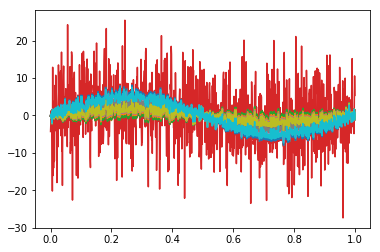

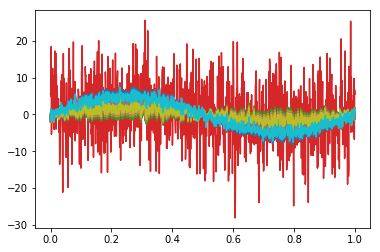

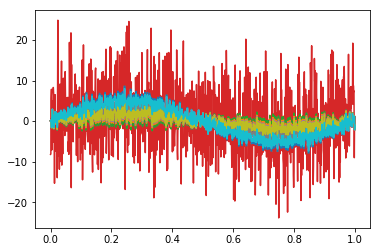

Shapes Equal?: True
Python head
[[ 0.48806763  0.44110288 -0.88067934  0.93877912 -2.32366679  0.52846242
  -0.27122536 -0.59902845  0.39690594  1.28128196]
 [-0.37139743 -0.26895995  0.49606846  0.13578374 -1.98399681  0.06853382
   0.42854366  0.80330537 -1.15657138  1.8486905 ]]
MATLAB Head
[[ 0.46302161  0.41846693 -0.83548578  0.89060407 -2.20442387  0.50134347
  -0.25730697 -0.56828829  0.37653803  1.21553079]
 [-0.35233854 -0.25515782  0.47061186  0.12881577 -1.88218464  0.06501689
   0.40655222  0.76208239 -1.09721995  1.75382181]]
False
MATLAB has any NaNs?: False
Python has any NaNs?: False
Arrays close (.1) tolerance?: False
Badelecs recognized the same?: True
All electrode/trial rejections the same?: False


In [340]:
for i in range(10):
    out = StringIO.StringIO()
    test_dat = success3()
    for j in range(3):
        for k in range(50):
            plt.plot(np.linspace(0,1,1000), test_dat[0][k,j,:])
        plt.show()
    mat_test_dat = np.swapaxes(test_dat[0], 1, 2)
    mat_jp, mat_rej = eng.jointprob(to_matlab_comp(mat_test_dat), 1, [], 1, 1000.0, nargout = 2, stdout = out)
    py_jp, py_rej, py_unnorm = jointprob(test_dat[0], [1], np.asarray([]), 1, 1000)
    mat_jp = np.asarray(mat_jp)
    mat_rej = np.asarray(mat_rej)
    # See results
    print "Shapes Equal?:", py_jp.shape == mat_jp.shape
    print "Python head"
    print py_jp[0:2,:]
    print "MATLAB Head"
    print mat_jp[0:2,:]
    print np.all(np.isclose(py_jp, mat_jp, atol=.1, equal_nan=True))
    print "MATLAB has any NaNs?:", np.isnan(mat_jp).any()
#     print "Python vals bad elec"
#     print py_jp[test_dat[2][0]]
#     print py_rej[0][test_dat[2][0]]
#     print "MATLAB vals bad elec"
#     print mat_jp[test_dat[2][0]]
#     print mat_rej[test_dat[2][0]]
    print "Python has any NaNs?:", np.isnan(py_jp).any()
    print "Arrays close (.1) tolerance?:", np.isclose(py_jp, mat_jp, atol=.1).all()
    print "Badelecs recognized the same?:", np.array_equal(py_rej[0][test_dat[2][0]], mat_rej[test_dat[2][0]])
    print "All electrode/trial rejections the same?:", np.array_equal(py_rej, mat_rej)
    rej_differences = np.logical_xor(py_rej, mat_rej)
    rej_locs = np.where(np.any(rej_differences))

In [341]:
# List all patient names
patient_names = [
    "gp_A00051826001",
    "bip_A00053375001",
    "gip_A00051955001",
    "gip_A00053440001",
    "gip_A00054417001",
    "bip_A00054215001",
    "gip_A00054207001",
    "gp_A00054039001"
]

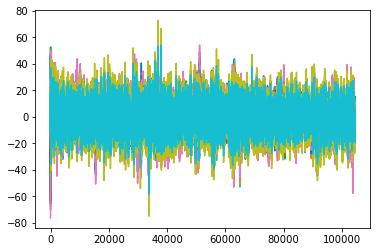

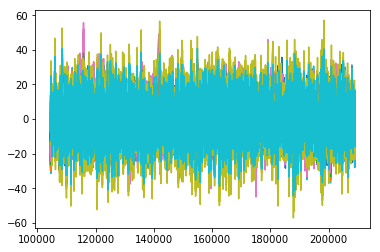

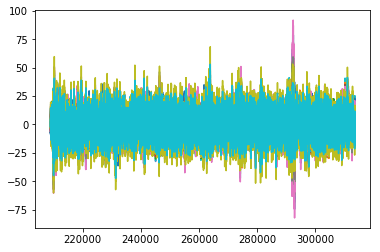

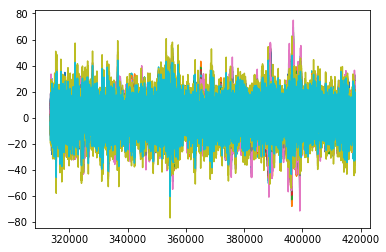

In [ ]:
for name in patient_names:
    out = StringIO.StringIO()
    # get patient data
    patient, time, zero = list(get_patient(name + ".mat")[i] for i in [0, 1, 4])
    # get rid of 0 electrodes
    test_dat = patient[:, list(set(range(111)) - set(zero))]
    # reshape data with trials
    num_trials = 4
    test_dat = trials(test_dat, num_trials)
    for j in range(num_trials):
        for k in range(50):
            plt.plot(time[j * len(time)/num_trials : j * len(time)/num_trials + 52256], test_dat[k,j,:])
        plt.show()
    mat_test_dat = np.swapaxes(test_dat, 1, 2)
    mat_jp, mat_rej = eng.jointprob(to_matlab_comp(mat_test_dat), 3, [], 1, 1000.0, nargout = 2, stdout = out)
    py_jp, py_rej, py_unnorm = jointprob(test_dat, [3], np.asarray([]), 1, 1000)
    mat_jp = np.asarray(mat_jp)
    mat_rej = np.asarray(mat_rej)
    # See results
    print "Shapes Equal?:", py_jp.shape == mat_jp.shape
    print "Python head"
    print py_jp[0:2,:]
    print "MATLAB Head"
    print mat_jp[0:2,:]
    print np.all(np.isclose(py_jp, mat_jp, atol=.1, equal_nan=True))
    print "MATLAB has any NaNs?:", np.isnan(mat_jp).any()
#     print "Python vals bad elec"
#     print py_jp[test_dat[2][0]]
#     print py_rej[0][test_dat[2][0]]
#     print "MATLAB vals bad elec"
#     print mat_jp[test_dat[2][0]]
#     print mat_rej[test_dat[2][0]]
    print "Python has any NaNs?:", np.isnan(py_jp).any()
    print "Arrays close (.1) tolerance?:", np.isclose(py_jp, mat_jp, atol=.1).all()
#     print "Badelecs recognized the same?:", np.array_equal(py_rej[0][test_dat[2][0]], mat_rej[test_dat[2][0]])
    print "All electrode/trial rejections the same?:", np.array_equal(py_rej, mat_rej)